# Introduction

This notebook is a very basic and simple introductory primer to the method of ensembling models, in particular the variant of ensembling known as Stacking. In a nutshell stacking uses as a first-level (base), the predictions of a few basic machine learning models (classifiers) and then uses another model at the second-level to predict the output from the earlier first-level predictions.

The Titanic dataset is a prime candidate for introducing this concept as many newcomers to Kaggle start out here. Furthermore even though stacking has been responsible for many a team winning Kaggle competitions there seems to be a dearth of kernels on this topic so I hope this notebook can fill somewhat of that void.

I myself am quite a newcomer to the Kaggle scene as well and the first proper ensembling/stacking script that I managed to chance upon and study was one written in the AllState Severity Claims competition by the great Faron. The material in this notebook borrows heavily from Faron's script although ported to factor in ensembles of classifiers whilst his was ensembles of regressors. Anyway please check out his script here:

[Stacking Starter][1] : by Faron 


Now onto the notebook at hand and I hope that it manages to do justice and convey the concept of ensembling in an intuitive and concise manner.  My other standalone Kaggle [script][2] which implements exactly the same ensembling steps (albeit with different parameters) discussed below gives a Public LB score of 0.808 which is good enough to get to the top 9% and runs just under 4 minutes. Therefore I am pretty sure there is a lot of room to improve and add on to that script. Anyways please feel free to leave me any comments with regards to how I can improve


  [1]: https://www.kaggle.com/mmueller/allstate-claims-severity/stacking-starter/run/390867
  [2]: https://www.kaggle.com/arthurtok/titanic/simple-stacking-with-xgboost-0-808

In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.learning_curve import validation_curve
from sklearn.grid_search import GridSearchCV

# Feature Exploration, Engineering and Cleaning 

Now we will proceed much like how most kernels in general are structured, and that is to first explore the data on hand, identify possible feature engineering opportunities as well as numerically encode any categorical features.

In [2]:
# Load in the train and test datasets
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

In [3]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Well it is no surprise that our task is to somehow extract the information out of the categorical variables 

**Feature Engineering**

Here, credit must be extended to Sina's very comprehensive and well-thought out notebook for the feature engineering ideas so please check out his work 

[Titanic Best Working Classfier][1] : by Sina


  [1]: https://www.kaggle.com/sinakhorami/titanic/titanic-best-working-classifier

In [4]:
def get_Cabin_Class(name):
    if(type(name) == float):
        name = 'None'
    title_search = re.search('[A-Z]', name)
    if title_search:
        return title_search.group(0)
    return 'None'

train.Cabin.apply(get_Cabin_Class).value_counts().to_dict()
#train[train['Cabin'] == 'F G73']


{'A': 15,
 'B': 47,
 'C': 59,
 'D': 33,
 'E': 32,
 'F': 13,
 'G': 4,
 'N': 687,
 'T': 1}

In [5]:
full_data = [train, test]

# Some features of my own that I have added in
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
    
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
# def get_Cabin_Class(name):
#     if(type(name) == float):
#         return 'None'
#     title_search = re.search('[A-Z]', name).group(0)
#     if (title_search):
#         if(title_search == 'T'):
#             return 'None'
#         return title_search
#     return 'None'

# for dataset in full_data:
#     dataset['Cabin'] = dataset['Cabin'].apply(get_Cabin_Class)

# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

def data_mapping(dataset):
    #Mapping Cabin
    #cabin = pd.get_dummies(dataset['Cabin'], prefix='Cabin')
    
    # Mapping Sex
    #dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    sex = pd.get_dummies(dataset['Sex'],prefix='Sex')

    # Mapping titles
    #     title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    #     dataset['Title'] = dataset['Title'].map(title_mapping)
    #     dataset['Title'] = dataset['Title'].fillna(0)
    title = pd.get_dummies(dataset['Title'],prefix='Title')

    # Mapping Embarked
    #dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    embarked = pd.get_dummies(dataset['Embarked'],prefix='Embarked')

    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    #dataset['CategoricalFare'] = pd.qcut(train['Fare'], 4) #Lu's comment:  Mapping base on cut result on train set
    fare = pd.get_dummies(dataset['Fare'],prefix='Fare')

    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age']  				           = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']                           = 4;
    dataset['Age'] = dataset['Age'].astype(int)
    #dataset['Age'] = pd.cut(dataset['Age'], 5)  #Lu's comment:  Mapping base on cut result on train set
    age = pd.get_dummies(dataset['Age'],prefix='Age')
    
    # Mapping Pclass
    pclass = pd.get_dummies(dataset['Pclass'],prefix='Pclass')
    
    #dataset.join([sex,title,embarked,fare,age])
    dataset = pd.concat([dataset,sex,title,embarked,fare,age,pclass],axis= 1)
    dataset.drop(['Sex','Title','Embarked','Fare','Age','Pclass'], axis=1, inplace=True)
    return dataset

train = data_mapping(train)
test = data_mapping(test)
    #print(dataset)

In [6]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
#train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [7]:
train.columns.size

28

In [8]:
test.columns.size

27

All right so now having cleaned the features and extracted relevant information and dropped the categorical columns our features should now all be numeric, a format suitable to feed into our Machine Learning models. However before we proceed let us generate some simple correlation and distribution plots of our transformed dataset to observe ho

## Visualisations 

**Pearson Correlation Heatmap**

let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will utilise the Seaborn plotting package which allows us to plot heatmaps very conveniently as follows

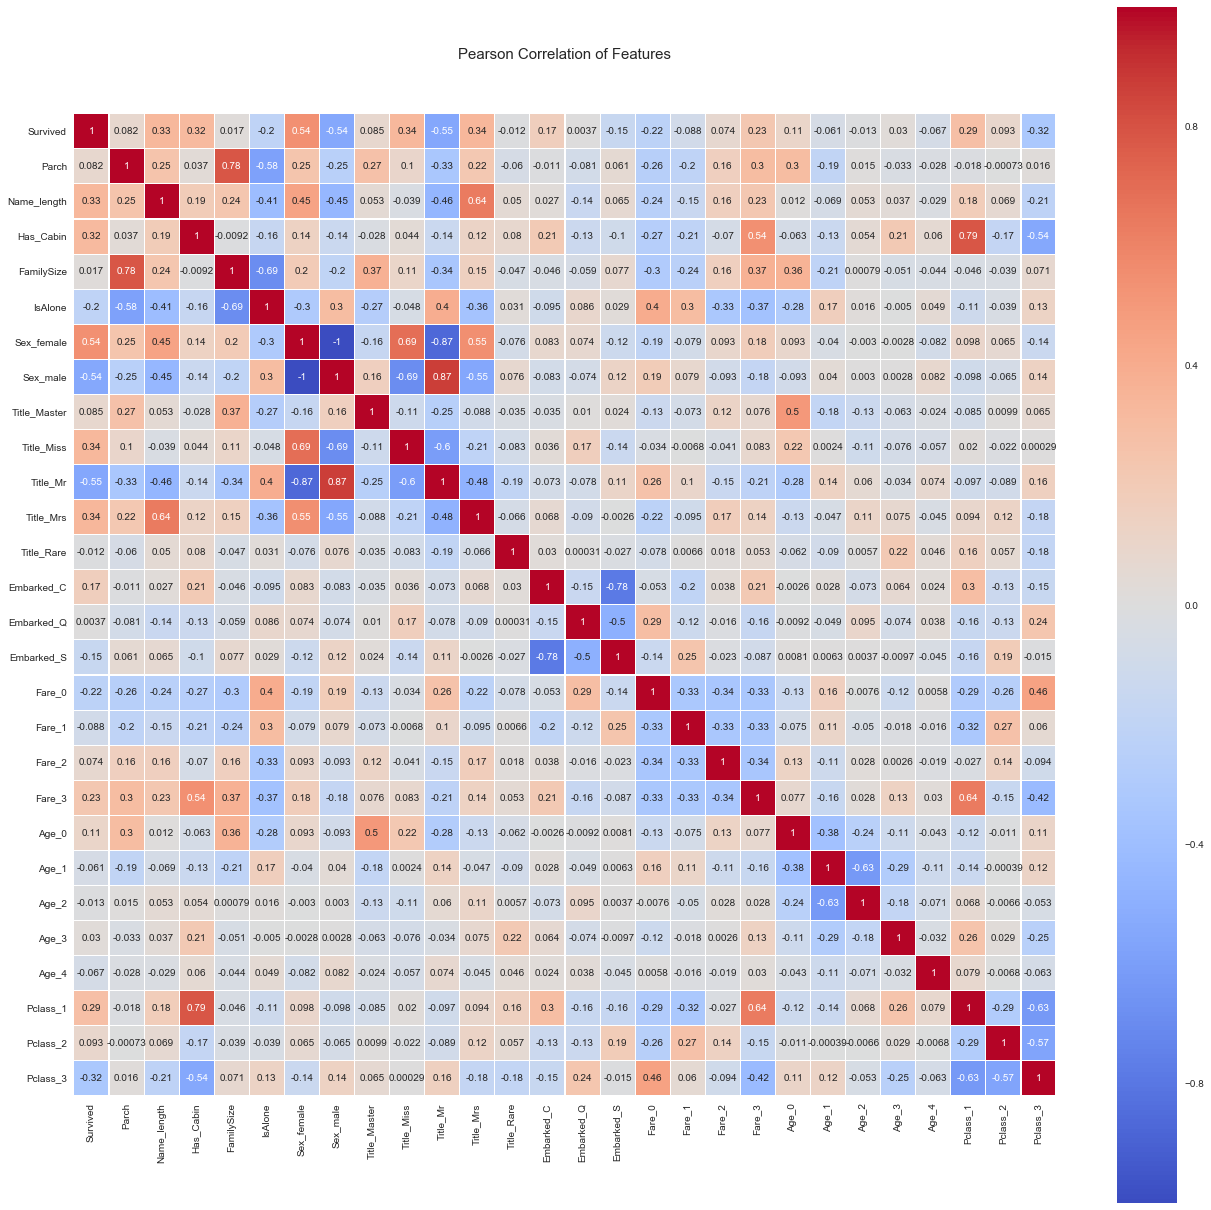

In [9]:
colormap = plt.cm.coolwarm
plt.figure(figsize=(22,22))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

**Takeaway from the Plots**

One thing that that the Pearson Correlation plot can tell us is that there are not too many features strongly correlated with one another. This is good from a point of view of feeding these features into your learning model because this means that there isn't much redundant or superfluous data in our training set and we are happy that each feature carries with it some unique information. Here are two most correlated features are that of Family size and Parch (Parents and Children). I'll still leave both features in for the purposes of this exercise.

**Pairplots**

Finally let us generate some pairplots to observe the distribution of data from one feature to the other. Once again we use Seaborn to help us.

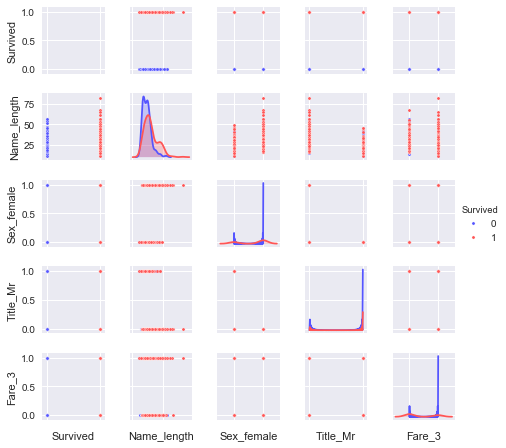

In [10]:
g = sns.pairplot(train[['Survived','Name_length','Sex_female','Title_Mr','Fare_3']], hue='Survived', palette = 'seismic',size=1.3,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

# Ensembling & Stacking models

Finally after that brief whirlwind detour with regards to feature engineering and formatting, we finally arrive at the meat and gist of the this notebook.

Creating a Stacking ensemble 

### Helpers via Python Classes

Here we invoke the use of Python's classes to help make it more convenient for us. For any newcomers to programming, one normally hears Classes being used in conjunction with Object-Oriented Programming (OOP). In short, a class helps to extend some code/program for creating objects (variables for old-school peeps) as well as to implement functions and methods specific to that class.

In the section of code below, we essentially write a class *SklearnHelper* that allows one to extend the inbuilt methods (such as train, predict and fit) common to all the Sklearn classifiers. Therefore this cuts out redundancy as  won't need to write the same methods five times if we wanted to invoke five different classifiers.

In [11]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        result = self.clf.fit(x,y).feature_importances_
        print(result)
        return result
# Class to extend XGboost classifer

In [12]:
ntrain

891

Bear with me for those who already know this but for people who have not created classes or objects in Python before, let me explain what the code given above does. In creating my base classifiers, I will only use the models already present in the Sklearn library and therefore only extend the class for that.

**def init** : Python standard for invoking the default constructor for the class. This means that when you want to create an object (classifier), you have to give it the parameters of clf (what sklearn classifier you want), seed (random seed) and params (parameters for the classifiers).

The rest of the code are simply methods of the class which simply call the corresponding methods already existing within the sklearn classifiers. 

### Out-of-Fold Predictions

Now as alluded to above in the introductory section, stacking uses predictions of base classifiers as input for training to a second-level model. However one cannot simply train the base models on the full training data, generate predictions on the full test set and then output these for the second-level training. This runs the risk of your base model predictions already having "seen" the test set and therefore overfitting when feeding these predictions.

In [13]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,)) # n * 1
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1) # 1 * n

# Generating our Base First-Level Models 

So now let us prepare five learning models as our first level classification. These models can all be conveniently invoked via the Sklearn library and are listed as follows:

 1. Random Forest classifier
 2. Extra Trees classifier
 3. AdaBoost classifer
 4. Gradient Boosting classifer
 5. Support Vector Machine

**Parameters**

Just a quick summary of the parameters that we will be listing here for completeness,

**n_jobs** : Number of cores used for the training process. If set to -1, all cores are used.

**n_estimators** : Number of classification trees in your learning model ( set to 10 per default)

**max_depth** : Maximum depth of tree, or how much a node should be expanded. Beware if set to too high  a number would run the risk of overfitting as one would be growing the tree too deep

**verbose** : Controls whether you want to output any text during the learning process. A value of 0 suppresses all text while a value of 3 outputs the tree learning process at every iteration.

 Please check out the full description via the official Sklearn website. There you will find that there are a whole host of other useful parameters that you can play around with. 

In [14]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

Furthermore, since having mentioned about Objects and classes within the OOP framework, let us now create 5 objects that represent our 5 learning models via our Helper Sklearn Class we defined earlier.

In [15]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

**Creating NumPy arrays out of our train and test sets**

Great. Having prepared our first layer base models as such, we can now ready the training and test test data for input into our classifiers by generating NumPy arrays out of their original dataframes as follows:

In [16]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

#standardization
stdsc = StandardScaler()
x_train = stdsc.fit_transform(x_train)
x_test = stdsc.transform(x_test)

**Output of the First level Predictions** 

We now feed the training and test data into our 5 base classifiers and use the Out-of-Fold prediction function we defined earlier to generate our first level predictions. Allow a handful of minutes for the chunk of code below to run.

In [17]:
x_train.shape

(891, 27)

In [18]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


**Feature importances generated from the different classifiers**

Now having learned our the first-level classifiers, we can utilise a very nifty feature of the Sklearn models and that is to output the importances of the various features in the training and test sets with one very simple line of code.

As per the Sklearn documentation, most of the classifiers are built in with an attribute which returns feature importances by simply typing in **.feature_importances_**. Therefore we will invoke this very useful attribute via our function earliand plot the feature importances as such

In [19]:
rf_features = rf.feature_importances(x_train,y_train)
et_features = et.feature_importances(x_train, y_train)
ada_features = ada.feature_importances(x_train, y_train)
gb_features = gb.feature_importances(x_train,y_train)

[ 0.01837142  0.07203597  0.05126685  0.05609454  0.01056569  0.13279217
  0.12635008  0.01732699  0.02599196  0.17876873  0.03342443  0.0081802
  0.01455721  0.00405593  0.01238266  0.01751002  0.00899796  0.01195744
  0.02016226  0.01035866  0.008013    0.00820178  0.00460383  0.00033066
  0.05139877  0.02018447  0.07611632]
[ 0.0106126   0.02419606  0.05371307  0.03053497  0.01164536  0.15641115
  0.15658288  0.02054471  0.03810489  0.16434628  0.04211618  0.00785841
  0.01337742  0.00830554  0.01650421  0.01602595  0.00868333  0.01205105
  0.0214685   0.0124521   0.00701013  0.01052549  0.00596251  0.00121863
  0.04175242  0.02850483  0.07949133]
[ 0.066  0.732  0.012  0.058  0.004  0.012  0.004  0.016  0.     0.002  0.
  0.01   0.002  0.006  0.006  0.006  0.01   0.006  0.002  0.004  0.004  0.
  0.006  0.004  0.022  0.     0.006]
[ 0.03053437  0.3810562   0.01897071  0.06332489  0.0174776   0.00879666
  0.00808426  0.00670961  0.03138891  0.0381847   0.00937706  0.0046495
  0.01748

So I have not yet figured out how to assign and store the feature importances outright. Therefore I'll print out the values from the code above and then simply copy and paste into Python lists as below (sorry for the lousy hack)

In [20]:
# rf_features = [0.10474135,  0.21837029,  0.04432652,  0.02249159,  0.05432591,  0.02854371
#   ,0.07570305,  0.01088129 , 0.24247496,  0.13685733 , 0.06128402]
# et_features = [ 0.12165657,  0.37098307  ,0.03129623 , 0.01591611 , 0.05525811 , 0.028157
#   ,0.04589793 , 0.02030357 , 0.17289562 , 0.04853517,  0.08910063]
# ada_features = [0.028 ,   0.008  ,      0.012   ,     0.05866667,   0.032 ,       0.008
#   ,0.04666667 ,  0.     ,      0.05733333,   0.73866667,   0.01066667]
# gb_features = [ 0.06796144 , 0.03889349 , 0.07237845 , 0.02628645 , 0.11194395,  0.04778854
#   ,0.05965792 , 0.02774745,  0.07462718,  0.4593142 ,  0.01340093]

Create a dataframe from the lists containing the feature importance data for easy plotting via the Plotly package.

In [21]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

**Interactive feature importances via Plotly scatterplots**

I'll use the interactive Plotly package at this juncture to visualise the feature importances values of the different classifiers 

In [22]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

Now let us calculate the mean of all the feature importances and store it as a new column in the feature importance dataframe

In [23]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.066,0.010613,0.030534,0.018371,Parch,0.031380
1,0.732,0.024196,0.381056,0.072036,Name_length,0.302322
2,0.012,0.053713,0.018971,0.051267,Has_Cabin,0.033988


**Plotly Barplot of Average Feature Importances**

Having obtained the mean feature importance across all our classifiers, we can plot them into a Plotly bar plot as follows:

In [34]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

# Second-Level Predictions from the First-level Output

**First-level output as new features**

Having now obtained our first-level predictions, one can think of it as essentially building a new set of features to be used as training data for the next classifier. As per the code below, we are therefore having as our new columns the first-level predictions from our earlier classifiers and we train the next classifier on this.

In [25]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,0.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


**Correlation Heatmap of the Second Level Training set**

In [26]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Portland',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

There have been quite a few articles and Kaggle competition winner stories about the merits of having trained models that are more uncorrelated with one another producing better scores.

In [27]:
x_train

array([[-0.47367361, -0.42745127, -0.54492498, ..., -0.56568542,
        -0.51015154,  0.90258736],
       [-0.47367361,  2.59096206,  1.835115  , ...,  1.76776695,
        -0.51015154, -1.10792599],
       [-0.47367361, -0.53525175, -0.54492498, ..., -0.56568542,
        -0.51015154,  0.90258736],
       ..., 
       [ 2.00893337,  1.40515682, -0.54492498, ..., -0.56568542,
        -0.51015154,  0.90258736],
       [-0.47367361, -0.64305222,  1.835115  , ...,  1.76776695,
        -0.51015154, -1.10792599],
       [-0.47367361, -0.85865317, -0.54492498, ..., -0.56568542,
        -0.51015154,  0.90258736]])

In [28]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [29]:
x_train.shape

(891, 5)

Having now concatenated and joined both the first-level train and test predictions as x_train and x_test, we can now fit a second-level learning model.

### Second level learning model via XGBoost

Here we choose the eXtremely famous library for boosted tree learning model, XGBoost. It was built to optimize large-scale boosted tree algorithms. For further information about the algorithm, check out the [official documentation][1].

  [1]: https://xgboost.readthedocs.io/en/latest/

Anyways, we call an XGBClassifier and fit it to the first-level train and target data and use the learned model to predict the test data as follows:

In [35]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(
    x_train, y_train,
    eval_set=[(x_train, y_train)], 
    eval_metric='logloss',
    verbose=True
)
predictions = gbm.predict(x_test)

[0]	validation_0-logloss:0.647256
[1]	validation_0-logloss:0.610148
[2]	validation_0-logloss:0.580113
[3]	validation_0-logloss:0.549875
[4]	validation_0-logloss:0.52374
[5]	validation_0-logloss:0.501913
[6]	validation_0-logloss:0.486422
[7]	validation_0-logloss:0.471168
[8]	validation_0-logloss:0.45794
[9]	validation_0-logloss:0.446693
[10]	validation_0-logloss:0.43662
[11]	validation_0-logloss:0.428077
[12]	validation_0-logloss:0.422295
[13]	validation_0-logloss:0.417579
[14]	validation_0-logloss:0.412294
[15]	validation_0-logloss:0.407352
[16]	validation_0-logloss:0.404565
[17]	validation_0-logloss:0.402231
[18]	validation_0-logloss:0.39912
[19]	validation_0-logloss:0.396872
[20]	validation_0-logloss:0.395439
[21]	validation_0-logloss:0.394125
[22]	validation_0-logloss:0.393267
[23]	validation_0-logloss:0.3917
[24]	validation_0-logloss:0.390037
[25]	validation_0-logloss:0.389189
[26]	validation_0-logloss:0.38815
[27]	validation_0-logloss:0.387214
[28]	validation_0-logloss:0.386644
[2

[232]	validation_0-logloss:0.379175
[233]	validation_0-logloss:0.379192
[234]	validation_0-logloss:0.379173
[235]	validation_0-logloss:0.379163
[236]	validation_0-logloss:0.379159
[237]	validation_0-logloss:0.37912
[238]	validation_0-logloss:0.379118
[239]	validation_0-logloss:0.379118
[240]	validation_0-logloss:0.379119
[241]	validation_0-logloss:0.379107
[242]	validation_0-logloss:0.379107
[243]	validation_0-logloss:0.379108
[244]	validation_0-logloss:0.379108
[245]	validation_0-logloss:0.37911
[246]	validation_0-logloss:0.379115
[247]	validation_0-logloss:0.379108
[248]	validation_0-logloss:0.37911
[249]	validation_0-logloss:0.37911
[250]	validation_0-logloss:0.37911
[251]	validation_0-logloss:0.37912
[252]	validation_0-logloss:0.37911
[253]	validation_0-logloss:0.379109
[254]	validation_0-logloss:0.37911
[255]	validation_0-logloss:0.379121
[256]	validation_0-logloss:0.379121
[257]	validation_0-logloss:0.379115
[258]	validation_0-logloss:0.379112
[259]	validation_0-logloss:0.379112


[461]	validation_0-logloss:0.377978
[462]	validation_0-logloss:0.37798
[463]	validation_0-logloss:0.377998
[464]	validation_0-logloss:0.377996
[465]	validation_0-logloss:0.378015
[466]	validation_0-logloss:0.377997
[467]	validation_0-logloss:0.37797
[468]	validation_0-logloss:0.377926
[469]	validation_0-logloss:0.377914
[470]	validation_0-logloss:0.377915
[471]	validation_0-logloss:0.3779
[472]	validation_0-logloss:0.377893
[473]	validation_0-logloss:0.3779
[474]	validation_0-logloss:0.377888
[475]	validation_0-logloss:0.377889
[476]	validation_0-logloss:0.377907
[477]	validation_0-logloss:0.377894
[478]	validation_0-logloss:0.377891
[479]	validation_0-logloss:0.37789
[480]	validation_0-logloss:0.377892
[481]	validation_0-logloss:0.37789
[482]	validation_0-logloss:0.377888
[483]	validation_0-logloss:0.377888
[484]	validation_0-logloss:0.377887
[485]	validation_0-logloss:0.377888
[486]	validation_0-logloss:0.37789
[487]	validation_0-logloss:0.377888
[488]	validation_0-logloss:0.377888
[

[690]	validation_0-logloss:0.377393
[691]	validation_0-logloss:0.377393
[692]	validation_0-logloss:0.377393
[693]	validation_0-logloss:0.377388
[694]	validation_0-logloss:0.377388
[695]	validation_0-logloss:0.377389
[696]	validation_0-logloss:0.377364
[697]	validation_0-logloss:0.377363
[698]	validation_0-logloss:0.377367
[699]	validation_0-logloss:0.377371
[700]	validation_0-logloss:0.377438
[701]	validation_0-logloss:0.377429
[702]	validation_0-logloss:0.377408
[703]	validation_0-logloss:0.377338
[704]	validation_0-logloss:0.37735
[705]	validation_0-logloss:0.377381
[706]	validation_0-logloss:0.377292
[707]	validation_0-logloss:0.377325
[708]	validation_0-logloss:0.377325
[709]	validation_0-logloss:0.377276
[710]	validation_0-logloss:0.377274
[711]	validation_0-logloss:0.377266
[712]	validation_0-logloss:0.37726
[713]	validation_0-logloss:0.377259
[714]	validation_0-logloss:0.377262
[715]	validation_0-logloss:0.377264
[716]	validation_0-logloss:0.377261
[717]	validation_0-logloss:0.3

[919]	validation_0-logloss:0.376989
[920]	validation_0-logloss:0.376989
[921]	validation_0-logloss:0.376987
[922]	validation_0-logloss:0.376985
[923]	validation_0-logloss:0.376942
[924]	validation_0-logloss:0.376943
[925]	validation_0-logloss:0.376942
[926]	validation_0-logloss:0.376941
[927]	validation_0-logloss:0.376941
[928]	validation_0-logloss:0.37694
[929]	validation_0-logloss:0.376941
[930]	validation_0-logloss:0.376939
[931]	validation_0-logloss:0.376941
[932]	validation_0-logloss:0.376938
[933]	validation_0-logloss:0.376938
[934]	validation_0-logloss:0.376938
[935]	validation_0-logloss:0.376941
[936]	validation_0-logloss:0.376938
[937]	validation_0-logloss:0.376945
[938]	validation_0-logloss:0.376957
[939]	validation_0-logloss:0.376956
[940]	validation_0-logloss:0.37695
[941]	validation_0-logloss:0.376938
[942]	validation_0-logloss:0.376939
[943]	validation_0-logloss:0.376942
[944]	validation_0-logloss:0.376966
[945]	validation_0-logloss:0.376981
[946]	validation_0-logloss:0.3

[1144]	validation_0-logloss:0.37674
[1145]	validation_0-logloss:0.376747
[1146]	validation_0-logloss:0.376747
[1147]	validation_0-logloss:0.376747
[1148]	validation_0-logloss:0.376747
[1149]	validation_0-logloss:0.376775
[1150]	validation_0-logloss:0.376775
[1151]	validation_0-logloss:0.376752
[1152]	validation_0-logloss:0.376766
[1153]	validation_0-logloss:0.376767
[1154]	validation_0-logloss:0.376766
[1155]	validation_0-logloss:0.376769
[1156]	validation_0-logloss:0.376766
[1157]	validation_0-logloss:0.376771
[1158]	validation_0-logloss:0.376771
[1159]	validation_0-logloss:0.376766
[1160]	validation_0-logloss:0.376761
[1161]	validation_0-logloss:0.376763
[1162]	validation_0-logloss:0.376762
[1163]	validation_0-logloss:0.376762
[1164]	validation_0-logloss:0.376756
[1165]	validation_0-logloss:0.376759
[1166]	validation_0-logloss:0.376758
[1167]	validation_0-logloss:0.376762
[1168]	validation_0-logloss:0.376756
[1169]	validation_0-logloss:0.376756
[1170]	validation_0-logloss:0.376756
[1

[1366]	validation_0-logloss:0.376571
[1367]	validation_0-logloss:0.376573
[1368]	validation_0-logloss:0.376576
[1369]	validation_0-logloss:0.376574
[1370]	validation_0-logloss:0.376576
[1371]	validation_0-logloss:0.376573
[1372]	validation_0-logloss:0.376574
[1373]	validation_0-logloss:0.37657
[1374]	validation_0-logloss:0.376571
[1375]	validation_0-logloss:0.376572
[1376]	validation_0-logloss:0.37657
[1377]	validation_0-logloss:0.37657
[1378]	validation_0-logloss:0.37657
[1379]	validation_0-logloss:0.37657
[1380]	validation_0-logloss:0.37657
[1381]	validation_0-logloss:0.37657
[1382]	validation_0-logloss:0.37657
[1383]	validation_0-logloss:0.37657
[1384]	validation_0-logloss:0.376575
[1385]	validation_0-logloss:0.376579
[1386]	validation_0-logloss:0.376575
[1387]	validation_0-logloss:0.376585
[1388]	validation_0-logloss:0.376578
[1389]	validation_0-logloss:0.37658
[1390]	validation_0-logloss:0.376578
[1391]	validation_0-logloss:0.376554
[1392]	validation_0-logloss:0.376549
[1393]	vali

[1589]	validation_0-logloss:0.376166
[1590]	validation_0-logloss:0.376171
[1591]	validation_0-logloss:0.376159
[1592]	validation_0-logloss:0.376177
[1593]	validation_0-logloss:0.376179
[1594]	validation_0-logloss:0.376182
[1595]	validation_0-logloss:0.376192
[1596]	validation_0-logloss:0.376177
[1597]	validation_0-logloss:0.376173
[1598]	validation_0-logloss:0.376173
[1599]	validation_0-logloss:0.376173
[1600]	validation_0-logloss:0.376173
[1601]	validation_0-logloss:0.376175
[1602]	validation_0-logloss:0.376174
[1603]	validation_0-logloss:0.376173
[1604]	validation_0-logloss:0.376176
[1605]	validation_0-logloss:0.37618
[1606]	validation_0-logloss:0.376173
[1607]	validation_0-logloss:0.376173
[1608]	validation_0-logloss:0.376177
[1609]	validation_0-logloss:0.376186
[1610]	validation_0-logloss:0.376185
[1611]	validation_0-logloss:0.376198
[1612]	validation_0-logloss:0.376168
[1613]	validation_0-logloss:0.376162
[1614]	validation_0-logloss:0.376161
[1615]	validation_0-logloss:0.376159
[1

[1812]	validation_0-logloss:0.376094
[1813]	validation_0-logloss:0.37609
[1814]	validation_0-logloss:0.37609
[1815]	validation_0-logloss:0.376079
[1816]	validation_0-logloss:0.376072
[1817]	validation_0-logloss:0.376102
[1818]	validation_0-logloss:0.376122
[1819]	validation_0-logloss:0.376122
[1820]	validation_0-logloss:0.376095
[1821]	validation_0-logloss:0.376078
[1822]	validation_0-logloss:0.376092
[1823]	validation_0-logloss:0.376104
[1824]	validation_0-logloss:0.376087
[1825]	validation_0-logloss:0.37609
[1826]	validation_0-logloss:0.376095
[1827]	validation_0-logloss:0.376044
[1828]	validation_0-logloss:0.376036
[1829]	validation_0-logloss:0.376025
[1830]	validation_0-logloss:0.376027
[1831]	validation_0-logloss:0.376039
[1832]	validation_0-logloss:0.376037
[1833]	validation_0-logloss:0.376038
[1834]	validation_0-logloss:0.376037
[1835]	validation_0-logloss:0.376037
[1836]	validation_0-logloss:0.376037
[1837]	validation_0-logloss:0.376038
[1838]	validation_0-logloss:0.37604
[1839

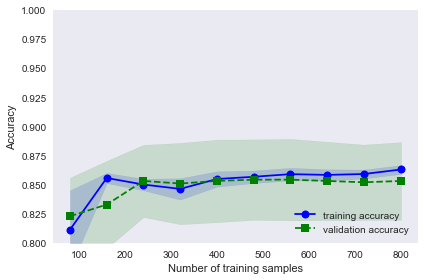

In [39]:
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve

param_dist = { 
    "n_estimators": 2000,
    "max_depth": 4,
    "min_child_weight": 2,
    #gamma=1,
    "gamma":0.9,                        
    "subsample":0.8,
    "colsample_bytree":0.8,
    "objective": 'binary:logistic',
    "nthread": -1,
    "scale_pos_weight":1
    }

clf = xgb.XGBClassifier(**param_dist)

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=clf,
                               X=x_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=8, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=8,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./figures/learning_curve.png', dpi=300)
plt.show()

#XGBoost eval example



# clf.fit(x_train, y_train,
#         eval_set=[(x_train, y_train)], 
#         eval_metric='logloss',
#         verbose=False)

# # Load evals result by calling the evals_result() function
# evals_result = clf.evals_result()

# print('Access logloss metric directly from validation_0:')
# print(evals_result['validation_0']['logloss'])

# print('')
# print('Access metrics through a loop:')
# for e_name, e_mtrs in evals_result.items():
#     print('- {}'.format(e_name))
#     for e_mtr_name, e_mtr_vals in e_mtrs.items():
#         print('   - {}'.format(e_mtr_name))
#         print('      - {}'.format(e_mtr_vals))
 
# print('')
# print('Access complete dict:')
#print(evals_result['validation_0']['logloss'][-1])

In [31]:
xgb_model = xgb.XGBClassifier()
clf = GridSearchCV(xgb_model,
                   {'max_depth': [3,4,5],
                    'n_estimators': [2000],
                    'gamma':[0.8,0.9,1],
                    "min_child_weight": [2,3],
                    "subsample":[0.8,0.9],
                    'colsample_bytree':[0.8],
                    "scale_pos_weight":[1]}, verbose=1)
clf.fit(x_train,y_train)

print('*' * 30)
print(clf.best_score_)
print('*' * 30)
print(clf.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  1.4min finished


******************************
0.8653198653198653
******************************
{'colsample_bytree': 0.8, 'gamma': 1, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 2000, 'scale_pos_weight': 1, 'subsample': 0.9}


Just a quick run down of the XGBoost parameters used in the model:

**max_depth** : How deep you want to grow your tree. Beware if set to too high a number might run the risk of overfitting.

**gamma** : minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be.

**eta** : step size shrinkage used in each boosting step to prevent overfitting

**Producing the Submission file**

Finally having trained and fit all our first-level and second-level models, we can now output the predictions into the proper format for submission to the Titanic competition as follows:

In [33]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

**Steps for Further Improvement**

As a closing remark it must be noted that the steps taken above just show a very simple way of producing an ensemble stacker. You hear of ensembles created at the highest level of Kaggle competitions which involves monstrous combinations of stacked classifiers as well as levels of stacking which go to more than 2 levels. 

Some additional steps that may be taken to improve one's score could be:

 1. Implementing a good cross-validation strategy in training the models to find optimal parameter values
 2. Introduce a greater variety of base models for learning. The more uncorrelated the results, the better the final score.

### Conclusion

I have this notebook has been helpful somewhat in introducing a working script for stacking learning models. Again credit must be extended to Faron and Sina. 

For other excellent material on stacking or ensembling in general, refer to the de-facto Must read article on the website MLWave: [Kaggle Ensembling Guide][1]. 

Till next time, Peace Out

  [1]: http://mlwave.com/kaggle-ensembling-guide/